# 04. PyTorch Custom Datasets Exercise Solutions

In [1]:
# Check for GPU
!nvidia-smi

Fri Jun 14 19:45:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Увеличение гибкости модели: Добавление дополнительных слоев или нейронов может помочь модели лучше улавливать сложные закономерности в данных.
2. Обучение с переносом: Использование предварительно обученных моделей и адаптация их под вашу задачу может ускорить процесс обучения и улучшить результаты.
3. Продление времени обучения: Увеличение количества эпох обучения дает модели больше шансов научиться распознавать закономерности.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# качаем пиццу, стэйки, суши
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# распакоука
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, suhsi data to data/pizza_steak_sushi


In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

[PosixPath('data/pizza_steak_sushi/train/pizza/68684.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/2190018.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/2992084.jpg')]
data/pizza_steak_sushi/train/sushi/307738.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/307738.jpg
Image class: sushi
Image height: 382
Image width: 512


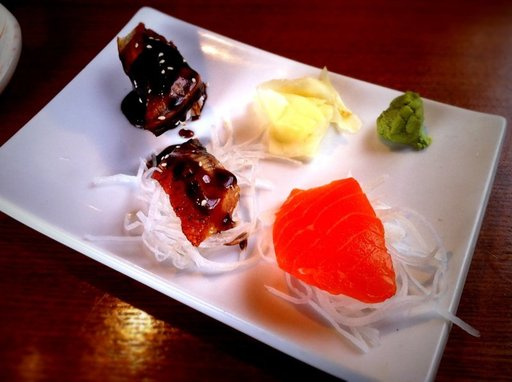

In [12]:
# Визуализация
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

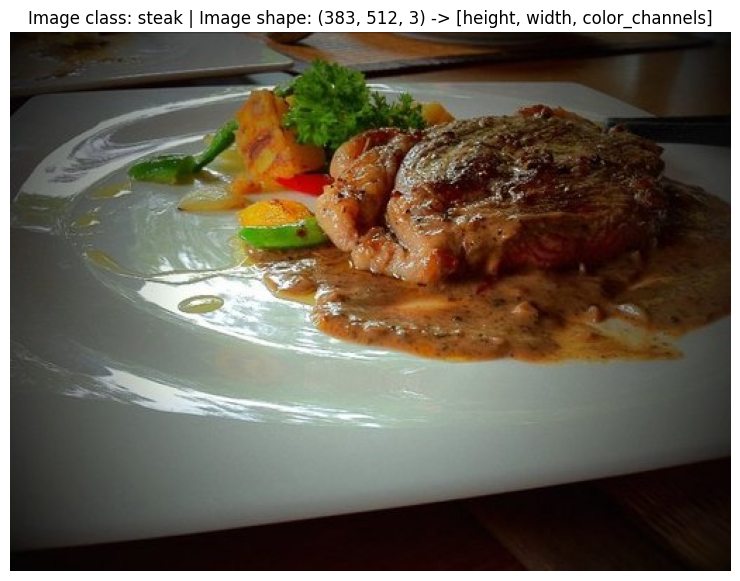

In [11]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# Изображение
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [14]:
data_transform = transforms.Compose([
  # ресайз делаем
  transforms.Resize(size=(64, 64)),
  # переворачиваем рандомно
  transforms.RandomHorizontalFlip(p=0.5),
  # делаем тензор
  transforms.ToTensor()
])

In [15]:
random.sample(image_path_list, k=3)

[PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1966300.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2163079.jpg')]

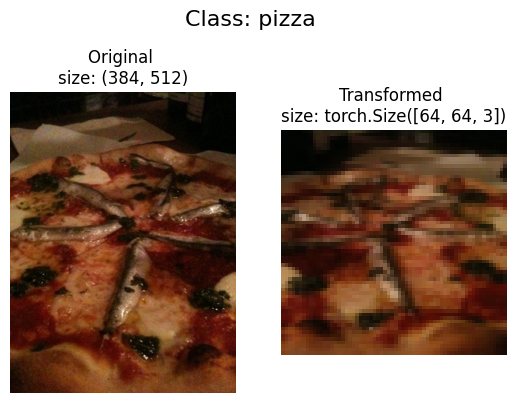

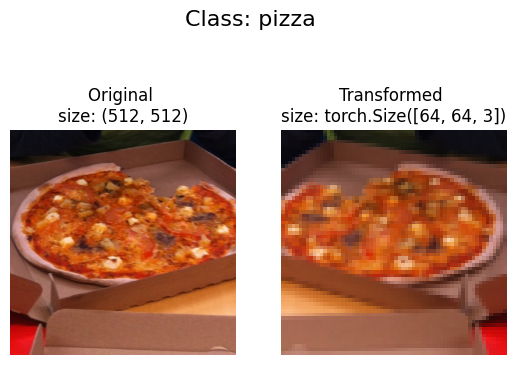

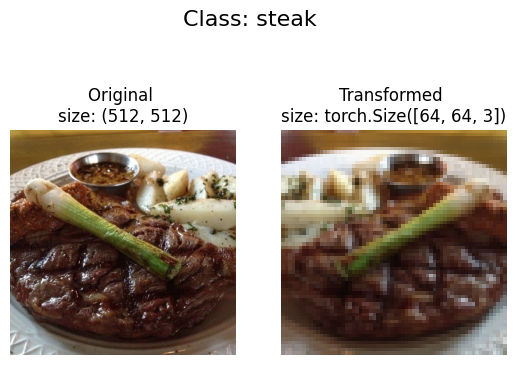

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [19]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
# получаем имя класса
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x780335e23d00>,
 <torch.utils.data.dataloader.DataLoader at 0x7803360ba680>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [27]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    print(f"Layer 3 shape: {x.shape}")
    return x

In [28]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [29]:
len(class_names)

3

In [30]:
16*16*10

2560

In [32]:
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])


tensor([[ 0.0329, -0.0086,  0.0221]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [33]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [34]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [35]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

In [36]:
# тренируем 5 эпох
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32

In [37]:
# 20 эпох
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: 

In [38]:
# 50 эпох
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 10, 32, 32])
Layer 2 shape: torch.Size([1, 10, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: 

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])
Layer 1 shape: 

Странно, но даже при изменении количества скрытых элементов модель всё равно переобучается.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [40]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [41]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [42]:
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [43]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: torch.Size([32, 20, 32, 32])
Layer 2 shape: torch.Size([32, 20, 16, 16])
Layer 3 shape: torch.Size([32, 3])
Layer 1 shape: t

Модель всё равно переобучается даже при удвоении объема данных(

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.

In [50]:
# Берем свое изображение
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://varnapizza.com/wp-content/uploads/2021/02/6-1.jpg")
  f.write(request.content)

In [51]:
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[ 64,  50,  47,  ..., 112, 122, 126],
         [ 77,  61,  51,  ..., 112, 119, 126],
         [ 92,  77,  62,  ..., 118, 120, 122],
         ...,
         [ 75,  61,  54,  ...,  83,  77,  85],
         [ 89,  69,  64,  ...,  95,  88,  82],
         [108,  75,  63,  ..., 107, 100,  79]],

        [[ 55,  41,  38,  ..., 103, 112, 116],
         [ 67,  51,  41,  ..., 102, 109, 116],
         [ 79,  64,  49,  ..., 105, 107, 109],
         ...,
         [ 60,  51,  54,  ...,  68,  60,  68],
         [ 74,  59,  62,  ...,  80,  71,  65],
         [ 95,  64,  59,  ...,  92,  83,  62]],

        [[ 46,  32,  29,  ...,  94, 103, 107],
         [ 58,  42,  32,  ...,  93, 100, 107],
         [ 71,  56,  43,  ...,  96,  98, 100],
         ...,
         [ 53,  42,  42,  ...,  61,  53,  61],
         [ 67,  50,  50,  ...,  73,  64,  58],
         [ 89,  58,  48,  ...,  85,  76,  55]]], dtype=torch.uint8)

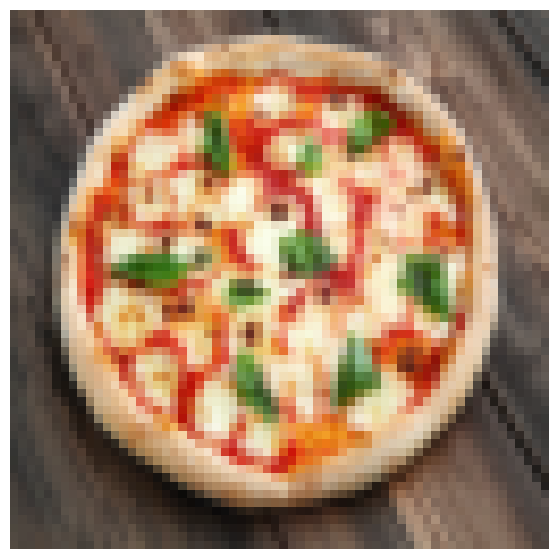

In [54]:
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False);

Layer 1 shape: torch.Size([1, 20, 32, 32])
Layer 2 shape: torch.Size([1, 20, 16, 16])
Layer 3 shape: torch.Size([1, 3])


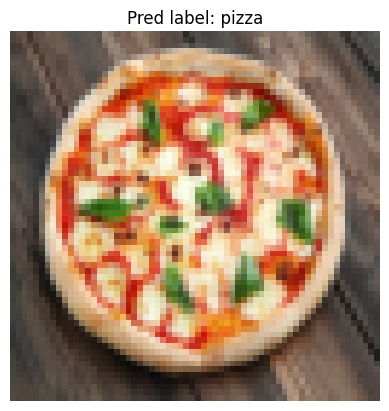

In [53]:
model_4.eval()
with torch.inference_mode():
  img = img / 255.
  resize = transforms.Resize((64, 64))
  img = resize(img)
  batch = img.unsqueeze(0).to(device)
  y_pred_logit = model_4(batch)
  pred_label = torch.argmax(y_pred_logit, dim=1)

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);